## v2 of youtrip statement extraction created on 2025-11-01

In [1]:
import pandas as pd
import requests
import pdfplumber
import re
import numpy as np
# import gspread
import csv
import time
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


# Test 1 page to verify that image borders are correct

This is my own path, you'd need to specifiy your personal path

In [2]:
# pdf = pdfplumber.open("/home/james/git/youtrip-statement-extraction/euro/youtrip_euro_statement_oct.pdf")
pdf = pdfplumber.open("/home/james/git/youtrip-statement-extraction/euro/youtrip_euro_statement_sep.pdf")
page = pdf.pages[0]

In [3]:
# Print all text from the page
print(page.extract_text())

KOH JUN WEI KOH
Y-8100805881
Y-8138408445
My EUR Statement Issued on 28 Oct 2025, 7:56 PM (SGT)
1 Sep 2025 to 30 Sep 2025
Transactions¹
Completed Date² Description Money Out Money In Balance
(in SGT)
1 Sep 2025 Opening Balance €0.00
SmartExchange™
23 Sep 2025 €40.00 €40.00
$60.56 SGD to €40.00 EUR
10:27 PM
FX rate: $1 SGD = €0.660501 EUR
PARK 3 CIME DI LAVARED,AURONZO
24 Sep 2025 DI C €40.00 €0.00
4:26 PM
30 Sep 2025 Closing Balance €0.00
Remarks:
1. Pending transactions are awaiting confirmation from Mastercard, and will not be shown on your statement until they're completed.
2. Completed date refers to the date that funds from your transaction were released to the merchant, and may not be the date you made your payment.
page 1 of 1


In [4]:
### your regex
end_of_row = [page.search(r'€\d{1,3}(?:,\d{3})*(?:\.\d{2})?')] # for EUR statements - matches values like €40.00, €131.50
first_line_after_header = [page.search(r'\bBalance\b')]
page_footer = [page.search(r'page \d+ of \d+')] # to detect end of page

In [5]:
### quick override of the above declaration of "page" for ez debugging
### this sample only extracts one page at a time. You may choose to put this block in a loop to extract multiple pages.
page = pdf.pages[0]

row_bottom_coordinates_list = []

### we use the final EUR value at the end of each row of the "balance" column as explicit delineation for horizonal line
end_of_row = [page.search(r'€\d{1,3}(?:,\d{3})*(?:\.\d{2})?')] # for EUR statements

for i in range(50):
    
    try:
        # fix the issue of regex picking up values from "smartexchange" transactions and creating unneccesary lines
        # this 556.96 is the coordinates of the end of right hand column
        if end_of_row[0][i]['x1'] > 550:
            # print(end_of_row_1[0][i]['text']) # for testing
            row_bottom_coordinates = end_of_row[0][i]['bottom']
            row_bottom_coordinates_list.append(row_bottom_coordinates)

    except IndexError:
        
        break

### remove duplicated fields due to same regex identified values occuring more than once in a "row"
row_bottom_coordinates_list = list(dict.fromkeys(row_bottom_coordinates_list))

### insert a horizontal line after the header, specifically after the word "Balance"
row_bottom_coordinates_list.insert(0,first_line_after_header[0][0]['bottom'])

print(row_bottom_coordinates_list)

[236.45799999999997, 272.9, 316.83000000000004, 367.86, 414.63]


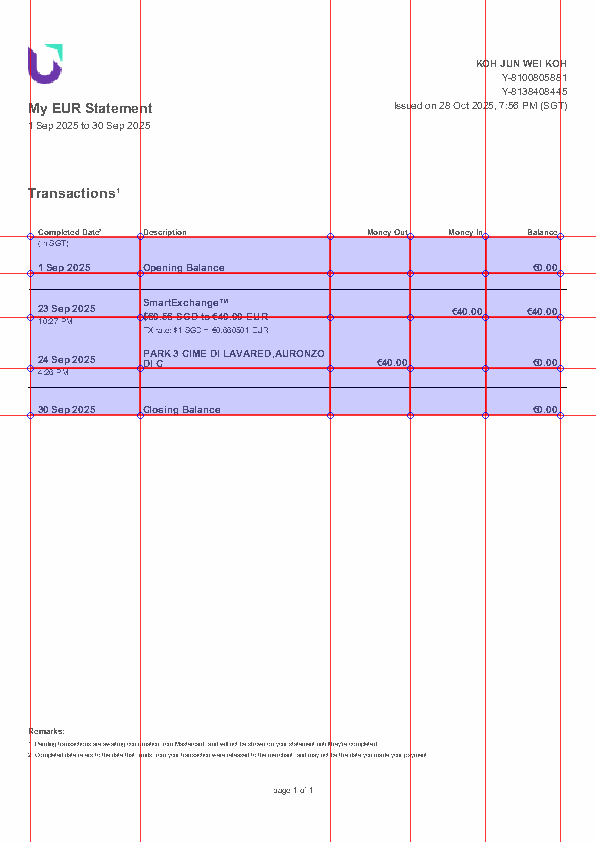

In [6]:

im = page.to_image()

im.reset().debug_tablefinder({
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "explicit",
    "explicit_horizontal_lines": row_bottom_coordinates_list,
    "explicit_vertical_lines": [ 30, 140, 330, 410, 485,560], # static hardcoded lines for youtrip statements
})

## Now we iterate through all pages

In [11]:
### Process all pages in the PDF
all_transactions = []

# Get total number of pages
total_pages = len(pdf.pages)
print(f"Processing {total_pages} pages...")

def split_description_string(cell):
    if '\n' in cell:
        # Replace \n with space instead of splitting
        return cell.replace('\n', ' ')
    else:
        return cell

def split_string(cell):
    if '\n' in cell:
        # Replace \n with space instead of splitting
        return cell.split('\n')[1]
    else:
        return cell

for page_num in range(total_pages):
    print(f"\nProcessing page {page_num + 1}")
    
    # Get current page
    page = pdf.pages[page_num]
    
    # Reset coordinates list for each page
    row_bottom_coordinates_list = []
    
    # Find balance header and currency values
    first_line_after_header = [page.search(r'\bBalance\b')]
    end_of_row = [page.search(r'€\d{1,3}(?:,\d{3})*(?:\.\d{2})?')]
    
    # Skip page if no balance header found (might be a cover page or different format)
    if not first_line_after_header[0]:
        print(f"Skipping page {page_num + 1} - no balance header found")
        continue
        
    # Process coordinates for current page
    for i in range(len(end_of_row[0])):
        try:
            if end_of_row[0][i]['x1'] > 550:
                row_bottom_coordinates = end_of_row[0][i]['bottom']
                row_bottom_coordinates_list.append(row_bottom_coordinates)
        except IndexError:
            break
    
    # Remove duplicates while preserving order
    row_bottom_coordinates_list = list(dict.fromkeys(row_bottom_coordinates_list))
    
    # Add header line
    row_bottom_coordinates_list.insert(0, first_line_after_header[0][0]['bottom'])
    
    # Extract table from current page
    page_transactions = page.extract_table({
        "vertical_strategy": "explicit", 
        "horizontal_strategy": "lines",
        "explicit_horizontal_lines": row_bottom_coordinates_list,
        "explicit_vertical_lines": [ 30, 140, 330, 410, 485, 560],
    })
    
    # Add page transactions to main list
    if page_transactions:
        all_transactions.extend(page_transactions)
        print(f"Found {len(page_transactions)} transactions on page {page_num + 1}")
    
    df_transactions = pd.DataFrame(all_transactions, columns=['date', 'description', 'money out', 'money in', 'balance'])
    df_transactions

    # Apply a custom function to clean cells with split string
    df_transactions['date'] = df_transactions['date'].apply(split_string)
    df_transactions['description'] = df_transactions['description'].apply(split_description_string)
    df_transactions['money out'] = df_transactions['money out'].apply(split_string)
    df_transactions['money in'] = df_transactions['money in'].apply(split_string)
    df_transactions['balance'] = df_transactions['balance'].apply(split_string)

    df_transactions

print(f"\nTotal transactions found: {len(all_transactions)}")

Processing 1 pages...

Processing page 1
Found 7 transactions on page 1

Total transactions found: 7


In [12]:
df_transactions

,date,description,money out,money in,balance
0,1 Sep 2025,Opening Balance,,,€0.00
1,,,,,
2,23 Sep 2025,SmartExchange™,,€40.00,€40.00
3,10:27 PM,$60.56 SGD to €40.00 EUR FX rate: $1 SGD = €0....,,,
4,24 Sep 2025,"PARK 3 CIME DI LAVARED,AURONZO DI C",€40.00,,€0.00
5,4:26 PM,,,,
6,30 Sep 2025,Closing Balance,,,€0.00


In [13]:
# Filter out only actual transactions
cleaned_transactions = df_transactions[
    # Keep rows where description is not empty
    (df_transactions["description"].str.strip() != "") & 
    # Remove SmartExchange and FX rows
    (~df_transactions["description"].str.contains("SmartExchange|FX", na=False)) &
    # Remove Opening Balance and Closing Balance
    (~df_transactions["description"].str.contains("Opening Balance|Closing Balance", na=False))
]

display(cleaned_transactions)

,date,description,money out,money in,balance
4,24 Sep 2025,"PARK 3 CIME DI LAVARED,AURONZO DI C",€40.00,,€0.00


# Export as CSV

In [15]:
cleaned_transactions.to_csv('youtrip_euro_statement_oct.csv', index=False)
print("CSV file has been exported successfully.")

CSV file has been exported successfully.
